# Data Science Bowl 2019

# Introduction

PBS KIDS, a trusted name in early childhood education for decades, aims to gain insights into how media can help children learn important skills for success in school and life. In this challenge, you’ll use anonymous gameplay data, including knowledge of videos watched and games played, from the PBS KIDS Measure Up! app, a game-based learning tool developed as a part of the CPB-PBS Ready To Learn Initiative with funding from the U.S. Department of Education. Competitors will be challenged to predict scores on in-game assessments and create an algorithm that will lead to better-designed games and improved learning outcomes. Your solutions will aid in discovering important relationships between engagement with high-quality educational media and learning processes.

**Where does the data for the competition come from?**
The data used in this competition is anonymous, tabular data of interactions with the PBS KIDS Measure Up! app. Select data, such as a user’s in-app assessment score or their path through the game, is collected by the PBS KIDS Measure Up! app, a game-based learning tool.

**What is the PBS KIDS Measure Up! app?**
In the PBS KIDS Measure Up! app, children ages 3 to 5 learn early STEM concepts focused on length, width, capacity, and weight while going on an adventure through Treetop City, Magma Peak, and Crystal Caves. Joined by their favorite PBS KIDS characters, children can also collect rewards and unlock digital toys as they play. 

Besides the info provided above by Kaggle, I found the following additional info on the website of the app:

Specific features of Measure Up! include:

* 19 unique measuring games.
* 10 measurement-focused video clips.
* Sticker books featuring favorite PBS KIDS characters.
* Rewards for completion of tasks.
* Embedded challenges and reports to help parents and caregivers monitor kids’ progress.
* Ability to track your child's progress using the PBS KIDS Super Vision companion app.

**Evaluation**
Submissions are scored based on the quadratic weighted kappa, which measures the agreement between two outcomes. This metric typically varies from 0 (random agreement) to 1 (complete agreement). In the event that there is less agreement than expected by chance, the metric may go below 0.

The outcomes in this competition are grouped into 4 groups (labeled accuracy_group in the data):

3: the assessment was solved on the first attempt

2: the assessment was solved on the second attempt

1: the assessment was solved after 3 or more attempts

0: the assessment was never solved



For each installation_id represented in the test set, you must predict the accuracy_group of the last assessment for that installation_id.

Note that the training set contains many installation_ids which never took assessments, whereas every installation_id in the test set made an attempt on at least one assessment.

The file train_labels.csv has been provided to show how these groups would be computed on the assessments in the training set. Assessment attempts are captured in event_code 4100 for all assessments except for Bird Measurer, which uses event_code 4110. If the attempt was correct, it contains "correct":true.

# Table of contents

* [1. Understanding the train data](#1.-Understanding-the-train-data)
* [2. Understanding the test set](#2.-Understanding-the-test-set)
* [3. Understanding and visualizing the train labels](#3.-Understanding-and-visualizing-the train-labels)
* [4. Feature engineering](#4.-Feature-engineering)

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
import matplotlib.pylab as plt
import calendar
import warnings
warnings.filterwarnings("ignore")


import datetime
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats

from sklearn.model_selection import GroupKFold
from typing import Any
from numba import jit

from sklearn import metrics
from itertools import product
import copy
import time

import random
seed = 1234
random.seed(seed)
np.random.seed(seed)

# import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier

In [2]:
%%time

train = pd.read_csv(r'D:\Artificial Intelligence\Kaggle\2019 Data Science Bowl\Data\train.csv')
test = pd.read_csv(r'D:\Artificial Intelligence\Kaggle\2019 Data Science Bowl\Data\test.csv')
train_labels = pd.read_csv(r'D:\Artificial Intelligence\Kaggle\2019 Data Science Bowl\Data\train_labels.csv')
specs = pd.read_csv(r'D:\Artificial Intelligence\Kaggle\2019 Data Science Bowl\Data\specs.csv')
sample_submission = pd.read_csv(r'D:\Artificial Intelligence\Kaggle\2019 Data Science Bowl\Data\sample_submission.csv')


Wall time: 53.1 s


# 1. Understanding the train data

In [3]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [4]:
train.shape

(11341042, 11)

So we have 11 million rows and just 11 columns. However, Kaggle provided the following note: Note that the training set contains many installation_ids which never took assessments, whereas every installation_id in the test set made an attempt on at least one assessment.

As there is no point in keeping training data that cannot be used for training anyway, I am getting rid of the installation_ids that never took an assessment
    

In [5]:
keep_id = train[train.type == "Assessment"][['installation_id']].drop_duplicates()
keep_id

,installation_id
2185,0006a69f
6881,0006c192
8038,00129856
10069,001d0ed0
11440,00225f67
14560,00279ac5
18278,002db7e3
21185,003372b0
24103,004c2091
25375,00634433


In [6]:
train = pd.merge(train, keep_id, on="installation_id", how="inner")
train

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,34ba1a28d02ba8ba,2019-08-06T04:57:18.904Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,4b57c9a59474a1b9,2019-08-06T04:57:45.301Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,2b9d5af79bcdb79f,2019-08-06T04:58:14.538Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,2b9d5af79bcdb79f,2019-08-06T04:58:14.615Z,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:16.680Z,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK
5,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:18.474Z,"{""coordinates"":{""x"":863,""y"":237,""stage_width"":...",0006a69f,4,4070,3937,Sandcastle Builder (Activity),Activity,MAGMAPEAK
6,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:19.365Z,"{""coordinates"":{""x"":817,""y"":617,""stage_width"":...",0006a69f,5,4070,4820,Sandcastle Builder (Activity),Activity,MAGMAPEAK
7,1bb5fbdb,2b9d5af79bcdb79f,2019-08-06T04:58:21.490Z,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,6,3110,6954,Sandcastle Builder (Activity),Activity,MAGMAPEAK
8,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:22.732Z,"{""coordinates"":{""x"":809,""y"":180,""stage_width"":...",0006a69f,7,4070,8187,Sandcastle Builder (Activity),Activity,MAGMAPEAK
9,5e812b27,2b9d5af79bcdb79f,2019-08-06T04:58:23.295Z,"{""size"":0,""coordinates"":{""x"":782,""y"":207,""stag...",0006a69f,8,4030,8745,Sandcastle Builder (Activity),Activity,MAGMAPEAK


As you can see, we have now lost about 3 million rows.

In [7]:
train.shape

(8294138, 11)

The number of unique installations in our "smaller" train set is now 4242.

In [8]:
keep_id.shape

(4242, 1)

I will first visualize some of the existing columns.

In [9]:
train.type.value_counts()

Game          4125872
Activity      3139703
Assessment     925345
Clip           103218
Name: type, dtype: int64

In [10]:
train.type.value_counts().index

Index(['Game', 'Activity', 'Assessment', 'Clip'], dtype='object')

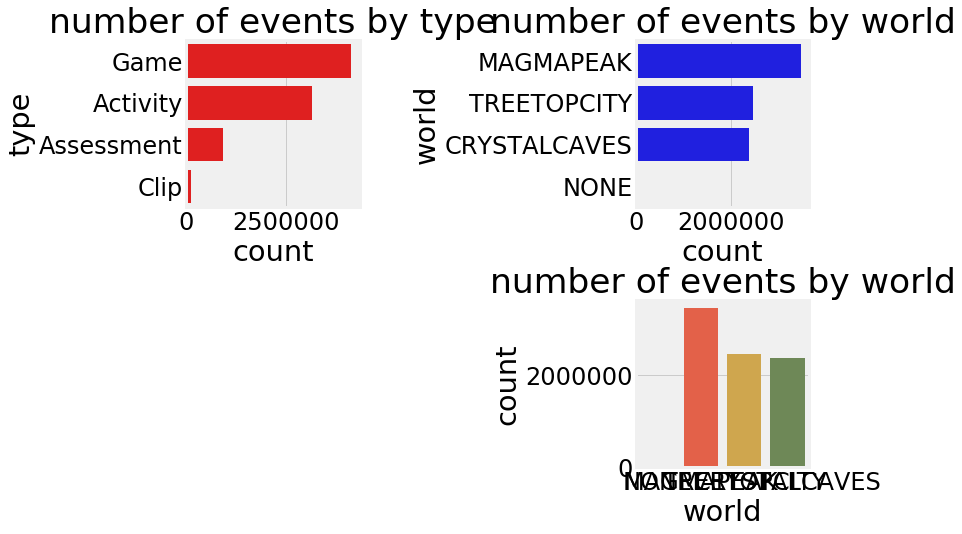

In [11]:
plt.rcParams.update({'font.size': 24})

fig = plt.figure(figsize=(12,10))

ax1 = fig.add_subplot(321)
ax1 = sns.countplot(y="type", order = train.type.value_counts().index, data=train, color="red" )
plt.title("number of events by type")

ax2 = fig.add_subplot(322)
ax2 = sns.countplot(y="world", order = train.world.value_counts().index, data=train, color="blue")
plt.title("number of events by world")

ax3 = fig.add_subplot(324)
ax3 = sns.countplot(x="world", data=train)
plt.title("number of events by world")

plt.tight_layout(pad=0)
plt.show()

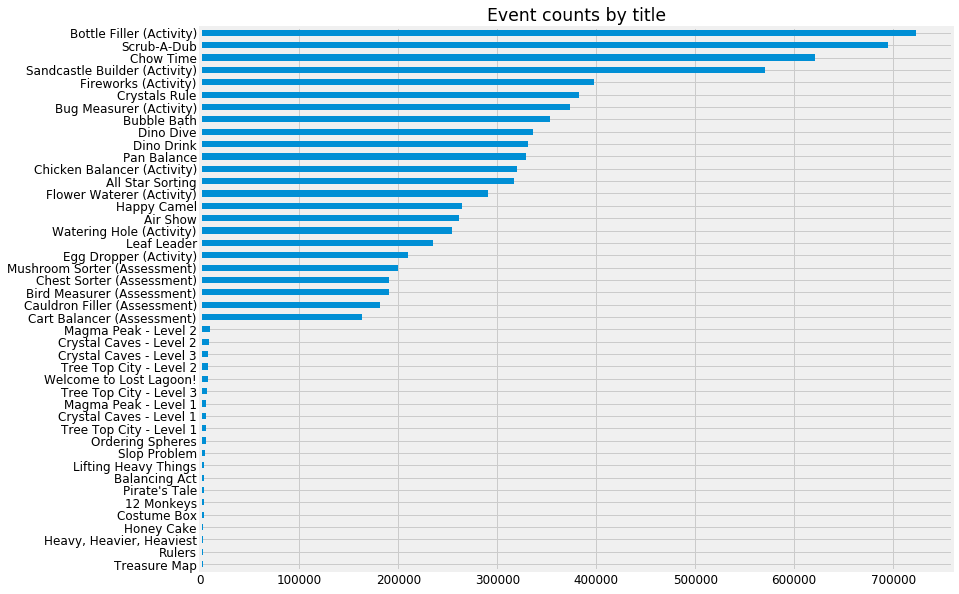

In [12]:
plt.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(12,10))

se = train.title.value_counts().sort_values(ascending=True)
se.plot.barh()
plt.title("Event counts by title")

plt.xticks(rotation=0)
plt.show()

I will now add some new columns based on the timestamp, and visualize these.

In [13]:
def get_time(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    return df
    

In [14]:
train = get_time(train)
train

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek
0,27253bdc,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,2019-08-06,8,4,1
1,27253bdc,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,2019-08-06,8,4,1
2,77261ab5,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
3,b2dba42b,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
4,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
5,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:18.474000+00:00,"{""coordinates"":{""x"":863,""y"":237,""stage_width"":...",0006a69f,4,4070,3937,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
6,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:19.365000+00:00,"{""coordinates"":{""x"":817,""y"":617,""stage_width"":...",0006a69f,5,4070,4820,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
7,1bb5fbdb,2b9d5af79bcdb79f,2019-08-06 04:58:21.490000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,6,3110,6954,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
8,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:22.732000+00:00,"{""coordinates"":{""x"":809,""y"":180,""stage_width"":...",0006a69f,7,4070,8187,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
9,5e812b27,2b9d5af79bcdb79f,2019-08-06 04:58:23.295000+00:00,"{""size"":0,""coordinates"":{""x"":782,""y"":207,""stag...",0006a69f,8,4030,8745,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1


Below your see the counts by date. By the way, I have wasted a lot of time on trying to fix the weird ticks on the x-axis, but this seems a bug: https://github.com/matplotlib/matplotlib/issues/13183

In [15]:
train.groupby('date')['date'].count()

date
2019-07-23      4558
2019-07-24     34576
2019-07-25     55561
2019-07-26     71748
2019-07-27     70122
2019-07-28     67619
2019-07-29     83244
2019-07-30     86377
2019-07-31     96490
2019-08-01     98206
2019-08-02    102937
2019-08-03     92888
2019-08-04     76959
2019-08-05     99589
2019-08-06    101570
2019-08-07     86221
2019-08-08    104489
2019-08-09     90826
2019-08-10     82536
2019-08-11     98329
2019-08-12     88604
2019-08-13     92008
2019-08-14     85334
2019-08-15     79202
2019-08-16     95027
2019-08-17    105768
2019-08-18    103233
2019-08-19     80805
2019-08-20     87333
2019-08-21     66510
               ...  
2019-09-16     88867
2019-09-17    119460
2019-09-18    129531
2019-09-19    121800
2019-09-20    121318
2019-09-21    106465
2019-09-22    109153
2019-09-23    104197
2019-09-24    134188
2019-09-25     98584
2019-09-26    118729
2019-09-27    127997
2019-09-28    121421
2019-09-29    116458
2019-09-30    134692
2019-10-01    118716
2019-10-

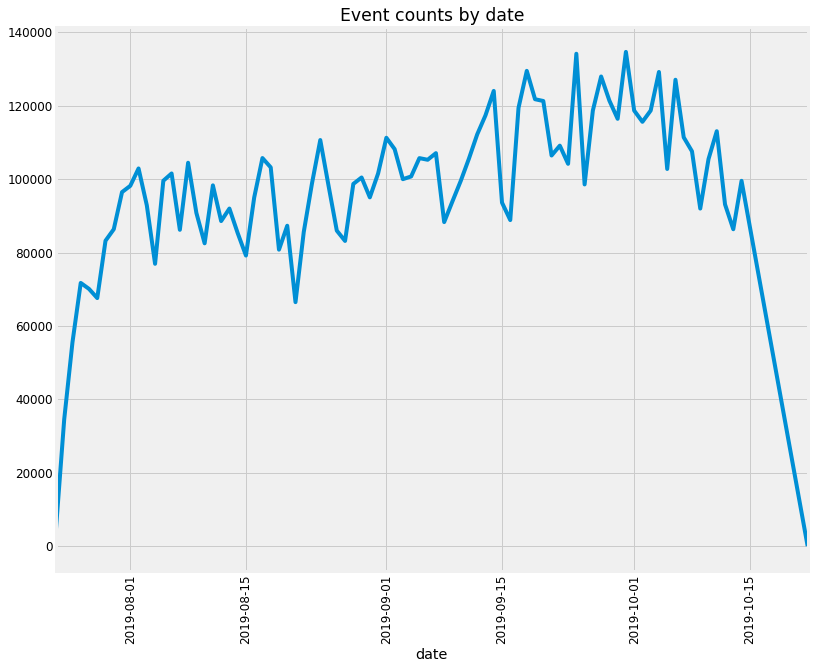

In [16]:
fig = plt.figure(figsize=(12,10))
se = train.groupby('date')['date'].count()
se.plot()
plt.title("Event counts by date")
plt.xticks(rotation=90)
plt.show()

When looking at the day of the week, we see no major difference. Of course, we are talking about kids who don't have to go to work ;-)

In [17]:
train.groupby('dayofweek')['dayofweek'].count()

dayofweek
0    1179160
1    1134579
2    1110013
3    1206276
4    1268847
5    1218555
6    1176708
Name: dayofweek, dtype: int64

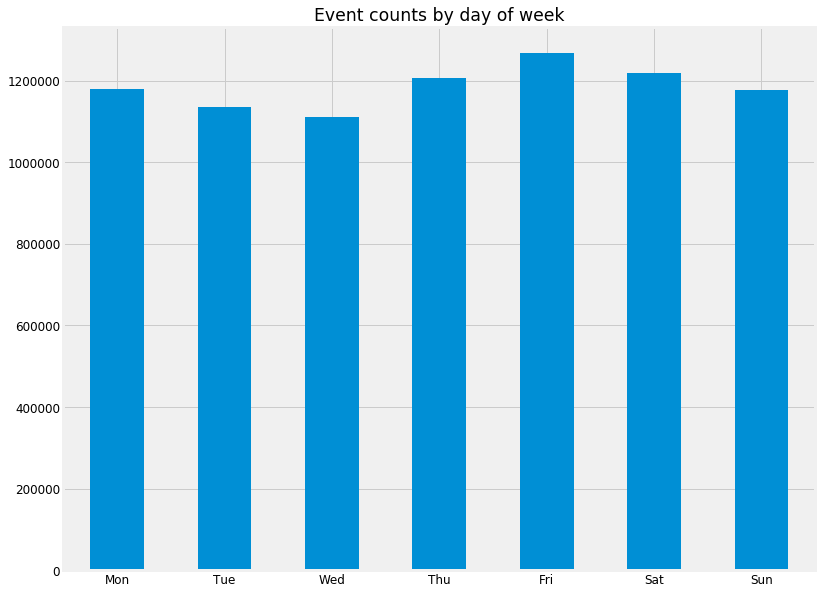

In [18]:
fig = plt.figure(figsize=(12,10))
se = train.groupby('dayofweek')['dayofweek'].count()
se.index = list(calendar.day_abbr)
se.plot.bar()
plt.title("Event counts by day of week")
plt.xticks(rotation=0)
plt.show()

When looking at the numbers by hour of the day, I find the distribution a little bit strange. Kids seem up late at night and don't do much early in the morning. Has this something to do with time zones perhaps?

In [19]:
train.groupby('hour')['hour'].count()

hour
0     525243
1     356248
2     251838
3     145352
4     103889
5      62361
6      37805
7      20974
8      17836
9      18326
10     49987
11    151354
12    289311
13    419251
14    564830
15    587714
16    602151
17    609127
18    612872
19    627990
20    602269
21    551214
22    540852
23    545344
Name: hour, dtype: int64

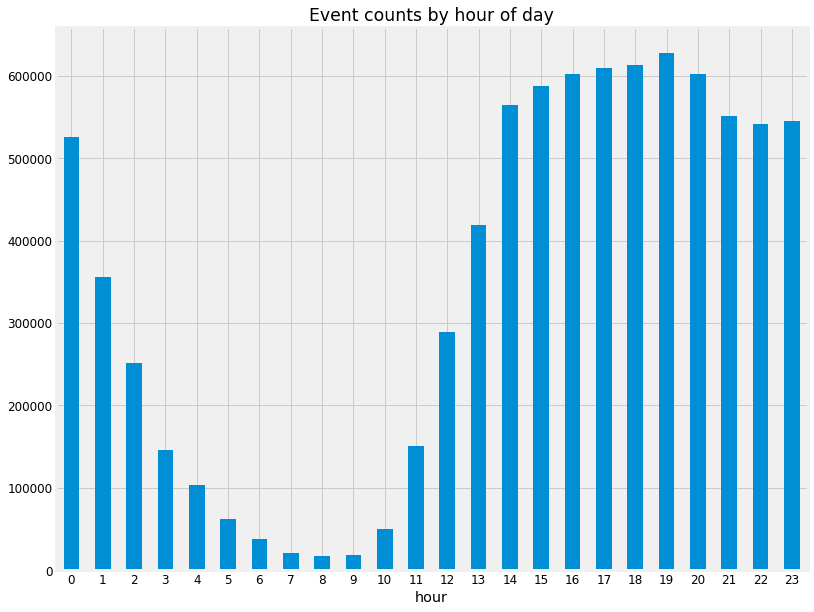

In [20]:
fig = plt.figure(figsize=(12,10))
se = train.groupby('hour')['hour'].count()
se.plot.bar()
plt.title("Event counts by hour of day")
plt.xticks(rotation=0)
plt.show()

# 2. Understanding the test set

From Kaggle: For each installation_id represented in the test set, you must predict the accuracy_group of the last assessment for that installation_id.

In [21]:
test.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In [22]:
test.shape

(1156414, 11)

In [23]:
test.installation_id.nunique()

1000

So we have 1.1 million rows on a thousand unique installation_ids in the test set. Below, you can see that we have this same amount of rows in the sample submission. This means that there are no installation_ids without assessment in the test set indeed.

In [24]:
sample_submission.shape[0]

1000

Another thing that I would like to check is if there is any overlap with regards to installation_id's in the train and test set. As you can see, there are no installation_id's that appear in both train and test.

In [25]:
len(train.installation_id.unique()),len(test.installation_id.unique())

(4242, 1000)

In [26]:
len(set(train.installation_id.unique())),len(set(test.installation_id.unique()))

(4242, 1000)

In [27]:
len(set(list(train.installation_id.unique())).intersection(set(list(test.installation_id.unique()))))

0

In [28]:
set(list(train.installation_id.unique())).intersection(set(list(test.installation_id.unique())))

set()

What about the date ranges?

In [29]:
train['timestamp'].dt.date.min()

datetime.date(2019, 7, 23)

In [30]:
test['timestamp'] = pd.to_datetime(test['timestamp'])
print(f'The date range in train is: {train.timestamp.dt.date.min()} to {train.timestamp.dt.date.max()}')
print(f'The date range in test is: {test.timestamp.dt.date.min()} to {test.timestamp.dt.date.max()}')

The date range in train is: 2019-07-23 to 2019-10-22
The date range in test is: 2019-07-24 to 2019-10-14


The date range is more or less the same, so we are talking about a dataset that seems (randomly) split on installation_id. Well actually "sort of" as Kaggle seems to have done this on installation_id's with assessments first, and added the "left-overs" with no assessments taken to the train set.

# 3. Understanding and visualizing the train labels

The outcomes in this competition are grouped into 4 groups (labeled accuracy_group in the data):

3: the assessment was solved on the first attempt

2: the assessment was solved on the second attempt

1: the assessment was solved after 3 or more attempts

0: the assessment was never solved


I started by visualizing some of these columns

In [31]:
train_labels.title.value_counts().index,train_labels.title.value_counts()

(Index(['Cart Balancer (Assessment)', 'Cauldron Filler (Assessment)',
        'Mushroom Sorter (Assessment)', 'Chest Sorter (Assessment)',
        'Bird Measurer (Assessment)'],
       dtype='object'), Cart Balancer (Assessment)      4151
 Cauldron Filler (Assessment)    4055
 Mushroom Sorter (Assessment)    3757
 Chest Sorter (Assessment)       2981
 Bird Measurer (Assessment)      2746
 Name: title, dtype: int64)

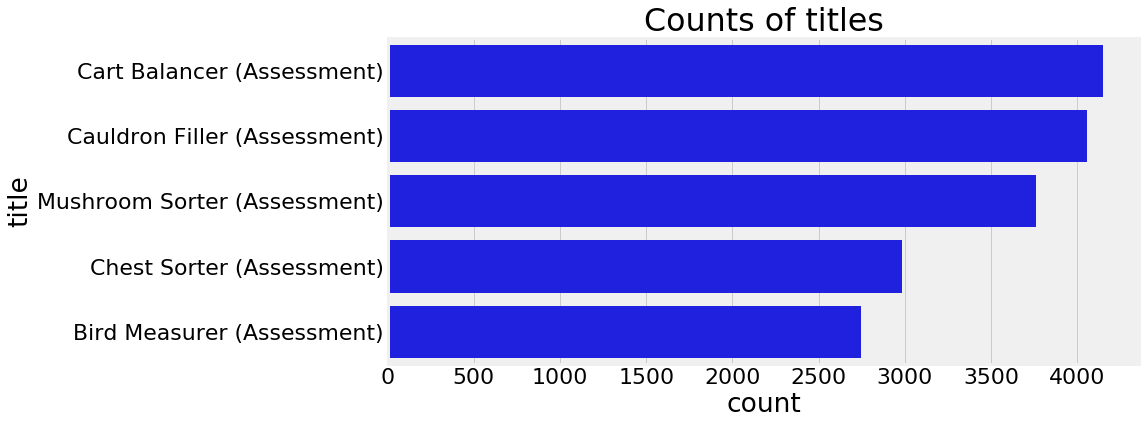

In [32]:
plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(12,6))
sns.countplot(y="title", data=train_labels, color="blue", order = train_labels.title.value_counts().index)
plt.title("Counts of titles")
plt.show()

Below, you can see that a lot of Chest Sorter assessments were never solved. Bird Measurer also seems hard with a relatively small amount solved on the first attempt.

In [33]:
train_labels.groupby(['title', 'accuracy_group'])['accuracy_group'].count()

title                         accuracy_group
Bird Measurer (Assessment)    0                  886
                              1                  778
                              2                  389
                              3                  693
Cart Balancer (Assessment)    0                  576
                              1                  353
                              2                  470
                              3                 2752
Cauldron Filler (Assessment)  0                  421
                              1                  459
                              2                  630
                              3                 2545
Chest Sorter (Assessment)     0                 1752
                              1                  466
                              2                  256
                              3                  507
Mushroom Sorter (Assessment)  0                  594
                              1                  355
 

In [34]:
train_labels.groupby(['title', 'accuracy_group'])['accuracy_group'].count().unstack('title')

title,Bird Measurer (Assessment),Cart Balancer (Assessment),Cauldron Filler (Assessment),Chest Sorter (Assessment),Mushroom Sorter (Assessment)
accuracy_group,,,,,
0,886,576,421,1752,594
1,778,353,459,466,355
2,389,470,630,256,460
3,693,2752,2545,507,2348


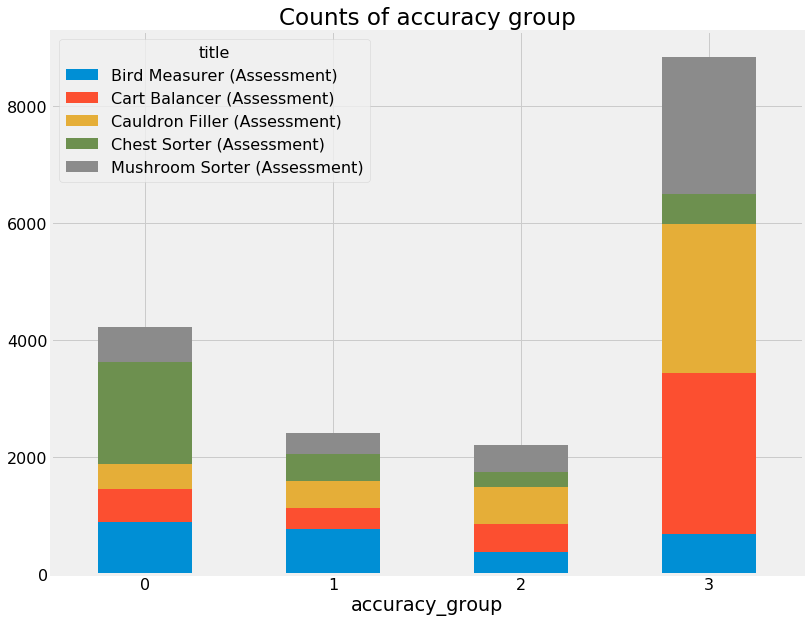

In [35]:
plt.rcParams.update({'font.size': 16})

se = train_labels.groupby(['title', 'accuracy_group'])['accuracy_group'].count().unstack('title')
se.plot.bar(stacked=True, rot=0, figsize=(12,10))
plt.title("Counts of accuracy group")
plt.show()

As the match between the train dataframe and the train_labels dataframe is not straightforward, it tried to figure out how these dataframes are to be matched by focussing on just one particular installation_id.

In [36]:
train_labels[train_labels.installation_id == "0006a69f"]

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


From Kaggle: The file train_labels.csv has been provided to show how these groups would be computed on the assessments in the training set. Assessment attempts are captured in event_code 4100 for all assessments except for Bird Measurer, which uses event_code 4110. If the attempt was correct, it contains "correct":true.

However, in the first version I already noticed that I had one attempt too many for this installation_id when mapping the rows with the train_labels for. It turns out that there are in fact also assessment attemps for Bird Measurer with event_code 4100, which should not count (see below). In this case that also makes sense as this installation_id already had a pass on the first attempt

In [37]:
(train
[
    (train.installation_id == "0006a69f") 
    &
    (train.type == "Assessment")
    &
    (
        (train.title != 'Bird Measurer (Assessment)') & (train.event_code == 4100)
            |
        (train.title == 'Bird Measurer (Assessment)') & (train.event_code == 4110) 
    )
])

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek
690,25fa8af4,901acc108f55a5a1,2019-08-06 05:22:32.357000+00:00,"{""correct"":true,""stumps"":[1,2,4],""event_count""...",0006a69f,44,4100,31011,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1171,17113b36,77b8ee947eb84b4e,2019-08-06 05:35:54.898000+00:00,"{""correct"":false,""caterpillars"":[11,8,3],""even...",0006a69f,29,4110,35771,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1177,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:01.927000+00:00,"{""correct"":false,""caterpillars"":[11,8,11],""eve...",0006a69f,35,4110,42805,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1182,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:06.512000+00:00,"{""correct"":false,""caterpillars"":[11,8,5],""even...",0006a69f,40,4110,47388,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1187,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:09.739000+00:00,"{""correct"":false,""caterpillars"":[11,8,7],""even...",0006a69f,45,4110,50605,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1192,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:13.951000+00:00,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,50,4110,54822,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1195,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:17.407000+00:00,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,53,4110,58280,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1200,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:21.390000+00:00,"{""correct"":false,""caterpillars"":[11,8,2],""even...",0006a69f,58,4110,62256,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1205,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:26.296000+00:00,"{""correct"":false,""caterpillars"":[11,8,1],""even...",0006a69f,63,4110,67164,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1
1212,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:32.187000+00:00,"{""correct"":false,""caterpillars"":[11,8,1],""even...",0006a69f,70,4110,73056,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,5,1


In [86]:
(train
[
    (train.installation_id == "0006a69f") 
    & 
    (train.event_code == 4100) & (train.title == "Bird Measurer (Assessment)")
])

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek
2615,070a5291,a9ef3ecb3d1acc6a,2019-08-06 20:50:33.283000+00:00,"{""correct"":true,""hats"":[4,8,5],""event_count"":3...",0006a69f,30,4100,34209,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,8,20,1


When we exclude the Bird Measurer/4100 rows we get the correct match with the numbers in train_labels for this installation_id (4 correct, 12 incorrect)

In [41]:
(train
[
    (train.installation_id == "0006a69f") 
    &
    (train.type == "Assessment")
    &
    (
      (train.event_code == 4100) & (train.title != 'Bird Measurer (Assessment)')
            |
       (train.event_code == 4110) & (train.title == 'Bird Measurer (Assessment)') 
    )
]).shape

(16, 15)

Now the question arises: Could there be installation_id's who did assessments (we have already taken out the ones who never took one), but without results in the train_labels? As you can see below, yes there are 628 of those.

In [88]:
train.installation_id.isin(train_labels.installation_id.unique())

0          True
1          True
2          True
3          True
4          True
5          True
6          True
7          True
8          True
9          True
10         True
11         True
12         True
13         True
14         True
15         True
16         True
17         True
18         True
19         True
20         True
21         True
22         True
23         True
24         True
25         True
26         True
27         True
28         True
29         True
           ... 
8294108    True
8294109    True
8294110    True
8294111    True
8294112    True
8294113    True
8294114    True
8294115    True
8294116    True
8294117    True
8294118    True
8294119    True
8294120    True
8294121    True
8294122    True
8294123    True
8294124    True
8294125    True
8294126    True
8294127    True
8294128    True
8294129    True
8294130    True
8294131    True
8294132    True
8294133    True
8294134    True
8294135    True
8294136    True
8294137    True
Name: installation_id, L

In [89]:
train[~train.installation_id.isin(train_labels.installation_id.unique())].installation_id.nunique()

628

As we can not train on those installation_id's anyway, I am taking them out of the train set. This reduces our train set further from 8.3 million rows to 7.7 million.

In [90]:
train = train[train.installation_id.isin(train_labels.installation_id.unique())]
train.shape

(7734558, 15)

In [91]:
train

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek
0,27253bdc,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,2019-08-06,8,4,1
1,27253bdc,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,2019-08-06,8,4,1
2,77261ab5,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
3,b2dba42b,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
4,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
5,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:18.474000+00:00,"{""coordinates"":{""x"":863,""y"":237,""stage_width"":...",0006a69f,4,4070,3937,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
6,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:19.365000+00:00,"{""coordinates"":{""x"":817,""y"":617,""stage_width"":...",0006a69f,5,4070,4820,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
7,1bb5fbdb,2b9d5af79bcdb79f,2019-08-06 04:58:21.490000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,6,3110,6954,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
8,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:22.732000+00:00,"{""coordinates"":{""x"":809,""y"":180,""stage_width"":...",0006a69f,7,4070,8187,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
9,5e812b27,2b9d5af79bcdb79f,2019-08-06 04:58:23.295000+00:00,"{""size"":0,""coordinates"":{""x"":782,""y"":207,""stag...",0006a69f,8,4030,8745,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1


# 4. Feature engineering

Basically what we need to do is to compose aggregated features for each session of which we know the train label. Before I get started, I am quickly checking if game_session alone is the unique identifier in train_labels indeed.

In [92]:
print(f'Number of rows in train_labels: {train_labels.shape[0]}')
print(f'Number of unique game_sessions in train_labels: {train_labels.game_session.nunique()}')

Number of rows in train_labels: 17690
Number of unique game_sessions in train_labels: 17690


Ok, now that we have that confirmed, I my first step was initially to start by looking for values that are always the same for a game_session in the train dataframe. It turns out that the only one is world. I also checked if some of the datetime variables were unique, but this is not always the case (events within a session may cross midnight).

Of course, on Kaggle it is not always necessary to reinvent the wheel. I knew that I would have to iterate over all the rows and add features that only look at what happened up to the moment at which the an installation_id starts a particluar assessment. I found out that Massoud Hosseinali already posted fantastic code on how to do that in this kernel: https://www.kaggle.com/mhviraf/a-new-baseline-for-dsb-2019-catboost-model. Thanks Massoud, and all credit go to you! As Bruno Aquino reused this code and already added some comments, I am actually using his code.

As I figured out that datetime variables cannot be matched uniquely to the train_labels, I am starting again with a train dataframe as it originally was (except for keeping timestamp as datetime). The huge code chunck below contains the function to generate features for each row in train_labels.

In [93]:
train

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,month,hour,dayofweek
0,27253bdc,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,2019-08-06,8,4,1
1,27253bdc,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,2019-08-06,8,4,1
2,77261ab5,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
3,b2dba42b,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
4,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
5,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:18.474000+00:00,"{""coordinates"":{""x"":863,""y"":237,""stage_width"":...",0006a69f,4,4070,3937,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
6,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:19.365000+00:00,"{""coordinates"":{""x"":817,""y"":617,""stage_width"":...",0006a69f,5,4070,4820,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
7,1bb5fbdb,2b9d5af79bcdb79f,2019-08-06 04:58:21.490000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,6,3110,6954,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
8,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:22.732000+00:00,"{""coordinates"":{""x"":809,""y"":180,""stage_width"":...",0006a69f,7,4070,8187,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1
9,5e812b27,2b9d5af79bcdb79f,2019-08-06 04:58:23.295000+00:00,"{""size"":0,""coordinates"":{""x"":782,""y"":207,""stag...",0006a69f,8,4030,8745,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,8,4,1


In [94]:
train = train.drop(['date', 'month', 'hour', 'dayofweek'], axis=1)

In [98]:
train.shape, train_labels.shape

((7734558, 11), (17690, 7))

In [100]:
title_event_code=list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
title_event_code

['Welcome to Lost Lagoon!_2000',
 'Magma Peak - Level 1_2000',
 'Sandcastle Builder (Activity)_2000',
 'Sandcastle Builder (Activity)_3010',
 'Sandcastle Builder (Activity)_4070',
 'Sandcastle Builder (Activity)_4070',
 'Sandcastle Builder (Activity)_4070',
 'Sandcastle Builder (Activity)_3110',
 'Sandcastle Builder (Activity)_4070',
 'Sandcastle Builder (Activity)_4030',
 'Sandcastle Builder (Activity)_3010',
 'Sandcastle Builder (Activity)_4021',
 'Sandcastle Builder (Activity)_4070',
 'Sandcastle Builder (Activity)_3110',
 'Sandcastle Builder (Activity)_4030',
 'Sandcastle Builder (Activity)_4021',
 'Sandcastle Builder (Activity)_4070',
 'Sandcastle Builder (Activity)_4030',
 'Sandcastle Builder (Activity)_3010',
 'Sandcastle Builder (Activity)_4021',
 'Sandcastle Builder (Activity)_4030',
 'Sandcastle Builder (Activity)_3110',
 'Sandcastle Builder (Activity)_4020',
 'Sandcastle Builder (Activity)_3010',
 'Sandcastle Builder (Activity)_4030',
 'Sandcastle Builder (Activity)_3110',
 

In [103]:
list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
list_of_user_activities

['Costume Box',
 'Bottle Filler (Activity)',
 'Heavy, Heavier, Heaviest',
 'Flower Waterer (Activity)',
 'Chow Time',
 'Cart Balancer (Assessment)',
 'Magma Peak - Level 1',
 'Cauldron Filler (Assessment)',
 'Dino Drink',
 'Chicken Balancer (Activity)',
 'Slop Problem',
 'Watering Hole (Activity)',
 'Bug Measurer (Activity)',
 'Tree Top City - Level 3',
 'Bubble Bath',
 '12 Monkeys',
 'Tree Top City - Level 2',
 'Crystal Caves - Level 1',
 'Welcome to Lost Lagoon!',
 'Leaf Leader',
 'Fireworks (Activity)',
 'Lifting Heavy Things',
 'Air Show',
 'Chest Sorter (Assessment)',
 'Magma Peak - Level 2',
 'Crystals Rule',
 'Crystal Caves - Level 2',
 'Crystal Caves - Level 3',
 'Bird Measurer (Assessment)',
 "Pirate's Tale",
 'Rulers',
 'Honey Cake',
 'Balancing Act',
 'All Star Sorting',
 'Happy Camel',
 'Tree Top City - Level 1',
 'Egg Dropper (Activity)',
 'Pan Balance',
 'Dino Dive',
 'Mushroom Sorter (Assessment)',
 'Scrub-A-Dub',
 'Ordering Spheres',
 'Sandcastle Builder (Activity)',
 '

In [104]:
list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
list_of_event_code

[2050,
 4100,
 2060,
 4110,
 2070,
 2075,
 2080,
 2081,
 2083,
 3110,
 3120,
 3121,
 4220,
 4230,
 5000,
 4235,
 5010,
 4010,
 4020,
 4021,
 4022,
 4025,
 4030,
 4031,
 3010,
 4035,
 4040,
 3020,
 3021,
 4045,
 2000,
 4050,
 2010,
 2020,
 4070,
 2025,
 2030,
 4080,
 2035,
 2040,
 4090,
 4095]

In [105]:
list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
list_of_event_id

['0ce40006',
 '05ad839b',
 '16dffff1',
 'ad2fc29c',
 '5859dfb6',
 'b80e5e84',
 '77261ab5',
 'c51d8688',
 'e5c9df6f',
 'ab3136ba',
 '6088b756',
 '87d743c1',
 'c54cf6c5',
 '160654fd',
 '8ac7cce4',
 'beb0a7b9',
 'a76029ee',
 'cfbd47c8',
 '90ea0bac',
 '4a4c3d21',
 '9de5e594',
 '37c53127',
 '7423acbc',
 'cc5087a3',
 '0d18d96c',
 '611485c5',
 'fd20ea40',
 '1af8be29',
 '74e5f8a7',
 '7040c096',
 'bbfe0445',
 '14de4c5d',
 'bd612267',
 '9d4e7b25',
 '6f8106d9',
 '4ef8cdd3',
 '93edfe2e',
 'c2baf0bd',
 '155f62a4',
 '5b49460a',
 'a5be6304',
 'e720d930',
 '73757a5e',
 '3dcdda7f',
 '9ed8f6da',
 '71fe8f75',
 'd38c2fd7',
 '58a0de5c',
 '6c517a88',
 '71e712d8',
 '3afb49e6',
 '3bb91ced',
 '7372e1a5',
 '9b01374f',
 'cf82af56',
 'c6971acf',
 'ecc36b7f',
 '6f445b57',
 '0330ab6a',
 '250513af',
 '3dfd4aa4',
 '2b9272f4',
 '8d84fa81',
 '2dc29e21',
 '7ad3efc6',
 '3afde5dd',
 'f50fc6c1',
 '3393b68b',
 '3b2048ee',
 'dcb55a27',
 '832735e1',
 '7961e599',
 'acf5c23f',
 '363c86c9',
 '5c3d2b2f',
 'b88f38da',
 '6cf7d25c',

In [110]:
list_of_user_activities, len(list_of_user_activities), np.arange(len(list_of_user_activities))

(['Costume Box',
  'Bottle Filler (Activity)',
  'Heavy, Heavier, Heaviest',
  'Flower Waterer (Activity)',
  'Chow Time',
  'Cart Balancer (Assessment)',
  'Magma Peak - Level 1',
  'Cauldron Filler (Assessment)',
  'Dino Drink',
  'Chicken Balancer (Activity)',
  'Slop Problem',
  'Watering Hole (Activity)',
  'Bug Measurer (Activity)',
  'Tree Top City - Level 3',
  'Bubble Bath',
  '12 Monkeys',
  'Tree Top City - Level 2',
  'Crystal Caves - Level 1',
  'Welcome to Lost Lagoon!',
  'Leaf Leader',
  'Fireworks (Activity)',
  'Lifting Heavy Things',
  'Air Show',
  'Chest Sorter (Assessment)',
  'Magma Peak - Level 2',
  'Crystals Rule',
  'Crystal Caves - Level 2',
  'Crystal Caves - Level 3',
  'Bird Measurer (Assessment)',
  "Pirate's Tale",
  'Rulers',
  'Honey Cake',
  'Balancing Act',
  'All Star Sorting',
  'Happy Camel',
  'Tree Top City - Level 1',
  'Egg Dropper (Activity)',
  'Pan Balance',
  'Dino Dive',
  'Mushroom Sorter (Assessment)',
  'Scrub-A-Dub',
  'Ordering Sphe

In [108]:
activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
activities_map

{'Costume Box': 0,
 'Bottle Filler (Activity)': 1,
 'Heavy, Heavier, Heaviest': 2,
 'Flower Waterer (Activity)': 3,
 'Chow Time': 4,
 'Cart Balancer (Assessment)': 5,
 'Magma Peak - Level 1': 6,
 'Cauldron Filler (Assessment)': 7,
 'Dino Drink': 8,
 'Chicken Balancer (Activity)': 9,
 'Slop Problem': 10,
 'Watering Hole (Activity)': 11,
 'Bug Measurer (Activity)': 12,
 'Tree Top City - Level 3': 13,
 'Bubble Bath': 14,
 '12 Monkeys': 15,
 'Tree Top City - Level 2': 16,
 'Crystal Caves - Level 1': 17,
 'Welcome to Lost Lagoon!': 18,
 'Leaf Leader': 19,
 'Fireworks (Activity)': 20,
 'Lifting Heavy Things': 21,
 'Air Show': 22,
 'Chest Sorter (Assessment)': 23,
 'Magma Peak - Level 2': 24,
 'Crystals Rule': 25,
 'Crystal Caves - Level 2': 26,
 'Crystal Caves - Level 3': 27,
 'Bird Measurer (Assessment)': 28,
 "Pirate's Tale": 29,
 'Rulers': 30,
 'Honey Cake': 31,
 'Balancing Act': 32,
 'All Star Sorting': 33,
 'Happy Camel': 34,
 'Tree Top City - Level 1': 35,
 'Egg Dropper (Activity)': 36

In [112]:
activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
activities_labels

{0: 'Costume Box',
 1: 'Bottle Filler (Activity)',
 2: 'Heavy, Heavier, Heaviest',
 3: 'Flower Waterer (Activity)',
 4: 'Chow Time',
 5: 'Cart Balancer (Assessment)',
 6: 'Magma Peak - Level 1',
 7: 'Cauldron Filler (Assessment)',
 8: 'Dino Drink',
 9: 'Chicken Balancer (Activity)',
 10: 'Slop Problem',
 11: 'Watering Hole (Activity)',
 12: 'Bug Measurer (Activity)',
 13: 'Tree Top City - Level 3',
 14: 'Bubble Bath',
 15: '12 Monkeys',
 16: 'Tree Top City - Level 2',
 17: 'Crystal Caves - Level 1',
 18: 'Welcome to Lost Lagoon!',
 19: 'Leaf Leader',
 20: 'Fireworks (Activity)',
 21: 'Lifting Heavy Things',
 22: 'Air Show',
 23: 'Chest Sorter (Assessment)',
 24: 'Magma Peak - Level 2',
 25: 'Crystals Rule',
 26: 'Crystal Caves - Level 2',
 27: 'Crystal Caves - Level 3',
 28: 'Bird Measurer (Assessment)',
 29: "Pirate's Tale",
 30: 'Rulers',
 31: 'Honey Cake',
 32: 'Balancing Act',
 33: 'All Star Sorting',
 34: 'Happy Camel',
 35: 'Tree Top City - Level 1',
 36: 'Egg Dropper (Activity)'

In [113]:
activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
activities_world

{'CRYSTALCAVES': 0, 'NONE': 1, 'TREETOPCITY': 2, 'MAGMAPEAK': 3}

In [114]:
assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
assess_titles

['Cauldron Filler (Assessment)',
 'Bird Measurer (Assessment)',
 'Chest Sorter (Assessment)',
 'Mushroom Sorter (Assessment)',
 'Cart Balancer (Assessment)']

In [115]:
train['title']

0                Welcome to Lost Lagoon!
1                   Magma Peak - Level 1
2          Sandcastle Builder (Activity)
3          Sandcastle Builder (Activity)
4          Sandcastle Builder (Activity)
5          Sandcastle Builder (Activity)
6          Sandcastle Builder (Activity)
7          Sandcastle Builder (Activity)
8          Sandcastle Builder (Activity)
9          Sandcastle Builder (Activity)
10         Sandcastle Builder (Activity)
11         Sandcastle Builder (Activity)
12         Sandcastle Builder (Activity)
13         Sandcastle Builder (Activity)
14         Sandcastle Builder (Activity)
15         Sandcastle Builder (Activity)
16         Sandcastle Builder (Activity)
17         Sandcastle Builder (Activity)
18         Sandcastle Builder (Activity)
19         Sandcastle Builder (Activity)
20         Sandcastle Builder (Activity)
21         Sandcastle Builder (Activity)
22         Sandcastle Builder (Activity)
23         Sandcastle Builder (Activity)
24         Sandc

In [106]:
list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
list_of_worlds

['CRYSTALCAVES', 'NONE', 'TREETOPCITY', 'MAGMAPEAK']

In [116]:
train_labels['title']

0        Mushroom Sorter (Assessment)
1          Bird Measurer (Assessment)
2        Mushroom Sorter (Assessment)
3        Mushroom Sorter (Assessment)
4          Bird Measurer (Assessment)
5        Cauldron Filler (Assessment)
6          Bird Measurer (Assessment)
7        Mushroom Sorter (Assessment)
8          Bird Measurer (Assessment)
9          Bird Measurer (Assessment)
10          Chest Sorter (Assessment)
11         Cart Balancer (Assessment)
12       Mushroom Sorter (Assessment)
13       Mushroom Sorter (Assessment)
14         Bird Measurer (Assessment)
15          Chest Sorter (Assessment)
16       Mushroom Sorter (Assessment)
17         Cart Balancer (Assessment)
18       Mushroom Sorter (Assessment)
19       Cauldron Filler (Assessment)
20         Bird Measurer (Assessment)
21          Chest Sorter (Assessment)
22         Bird Measurer (Assessment)
23         Bird Measurer (Assessment)
24          Chest Sorter (Assessment)
25         Cart Balancer (Assessment)
26       Cau

In [118]:
win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
win_code

{0: 4100,
 1: 4100,
 2: 4100,
 3: 4100,
 4: 4100,
 5: 4100,
 6: 4100,
 7: 4100,
 8: 4100,
 9: 4100,
 10: 4100,
 11: 4100,
 12: 4100,
 13: 4100,
 14: 4100,
 15: 4100,
 16: 4100,
 17: 4100,
 18: 4100,
 19: 4100,
 20: 4100,
 21: 4100,
 22: 4100,
 23: 4100,
 24: 4100,
 25: 4100,
 26: 4100,
 27: 4100,
 28: 4100,
 29: 4100,
 30: 4100,
 31: 4100,
 32: 4100,
 33: 4100,
 34: 4100,
 35: 4100,
 36: 4100,
 37: 4100,
 38: 4100,
 39: 4100,
 40: 4100,
 41: 4100,
 42: 4100,
 43: 4100}

In [122]:
activities_map['Bird Measurer (Assessment)']

28

In [121]:
win_code[activities_map['Bird Measurer (Assessment)']] = 4110
win_code

{0: 4100,
 1: 4100,
 2: 4100,
 3: 4100,
 4: 4100,
 5: 4100,
 6: 4100,
 7: 4100,
 8: 4100,
 9: 4100,
 10: 4100,
 11: 4100,
 12: 4100,
 13: 4100,
 14: 4100,
 15: 4100,
 16: 4100,
 17: 4100,
 18: 4100,
 19: 4100,
 20: 4100,
 21: 4100,
 22: 4100,
 23: 4100,
 24: 4100,
 25: 4100,
 26: 4100,
 27: 4100,
 28: 4110,
 29: 4100,
 30: 4100,
 31: 4100,
 32: 4100,
 33: 4100,
 34: 4100,
 35: 4100,
 36: 4100,
 37: 4100,
 38: 4100,
 39: 4100,
 40: 4100,
 41: 4100,
 42: 4100,
 43: 4100}

In [173]:
#Credits go to Andrew Lukyanenko

def encode_title(train, test, train_labels):
    
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    
    
    # encode title
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
   
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    
    
    
     # replace the text titles with the number titles from the dict
    train_labels['title'] = train_labels['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
        
    
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    
    
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    
    
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)

categoricals = ['session_title']

KeyError: 'Bird Measurer (Assessment)'

In [ ]:
train.shape

In [ ]:
time_spent_each_act = {actv: 0 for actv in list_of_user_activities}
time_spent_each_act

In [ ]:
sample_user.groupby('game_session', sort=False).count()

In [ ]:
win_code

In [192]:
sample_user = train[train.installation_id == "0006a69f"]
for i, session in sample_user.groupby('game_session', sort=False):
    if(i=="2b9d5af79bcdb79f"):
        session_type = session['type']
        session_title = session['title']
      
        print(session_type,"-",session_title)
        print(type(session))
       
        

2      Activity
3      Activity
4      Activity
5      Activity
6      Activity
7      Activity
8      Activity
9      Activity
10     Activity
11     Activity
12     Activity
13     Activity
14     Activity
15     Activity
16     Activity
17     Activity
18     Activity
19     Activity
20     Activity
21     Activity
22     Activity
23     Activity
24     Activity
25     Activity
26     Activity
27     Activity
28     Activity
29     Activity
30     Activity
31     Activity
         ...   
74     Activity
75     Activity
76     Activity
77     Activity
78     Activity
79     Activity
80     Activity
81     Activity
82     Activity
83     Activity
84     Activity
85     Activity
86     Activity
87     Activity
88     Activity
89     Activity
90     Activity
91     Activity
92     Activity
93     Activity
94     Activity
95     Activity
96     Activity
97     Activity
98     Activity
99     Activity
100    Activity
101    Activity
102    Activity
103    Activity
Name: type, Length: 102,

In [134]:
#Credits go to Massoud Hosseinali

def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # news features: time spent in each activity
    time_spent_each_act = {actv: 0 for actv in list_of_user_activities}
    event_code_count = {eve: 0 for eve in list_of_event_code}
    last_session_time_sec = 0
    
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy=0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0 
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title] #from Andrew
        
        
        # get current session time in seconds
        if session_type != 'Assessment':
            time_spent = int(session['game_time'].iloc[-1] / 1000)
            time_spent_each_act[activities_labels[session_title]] += time_spent
        
        
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
           
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
           
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            
            
            # copy a dict to use as feature template, it's initialized with some itenMs: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(time_spent_each_act.copy())
            features.update(event_code_count.copy())
            
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1] #from Andrew
            
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0] 
            
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        # this piece counts how many actions was made in each event_code so far
        n_of_event_codes = Counter(session['event_code'])
        
        for key in n_of_event_codes.keys():
            event_code_count[key] += n_of_event_codes[key]

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type
    # if test_set=True, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in train_set, all assessments are kept
    return all_assessments

To make this a little bit easier to understand, I am first using the function on one installation_id as an example (same one as used as an example before). Below, I have only displayed the last bunch of columns of the resulting dataframe. As you can see, five rows have been created for this installation_id.

In [175]:
train.shape, train_labels.shape

((7734558, 12), (17690, 7))

In [176]:
sample_id = train[train.installation_id == "0006a69f"]
sample_id

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,title_event_code
0,27253bdc,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,18,Clip,1,18_2000
1,27253bdc,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,6,Clip,3,6_2000
2,77261ab5,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,42,Activity,3,42_2000
3,b2dba42b,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,42,Activity,3,42_3010
4,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,42,Activity,3,42_4070
5,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:18.474000+00:00,"{""coordinates"":{""x"":863,""y"":237,""stage_width"":...",0006a69f,4,4070,3937,42,Activity,3,42_4070
6,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:19.365000+00:00,"{""coordinates"":{""x"":817,""y"":617,""stage_width"":...",0006a69f,5,4070,4820,42,Activity,3,42_4070
7,1bb5fbdb,2b9d5af79bcdb79f,2019-08-06 04:58:21.490000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,6,3110,6954,42,Activity,3,42_3110
8,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:22.732000+00:00,"{""coordinates"":{""x"":809,""y"":180,""stage_width"":...",0006a69f,7,4070,8187,42,Activity,3,42_4070
9,5e812b27,2b9d5af79bcdb79f,2019-08-06 04:58:23.295000+00:00,"{""size"":0,""coordinates"":{""x"":782,""y"":207,""stag...",0006a69f,8,4030,8745,42,Activity,3,42_4030


In [177]:
sample_id_data = get_data(sample_id) #returns a list
sample_id_data

[{'Clip': 11,
  'Activity': 3,
  'Assessment': 0,
  'Game': 4,
  'Costume Box': 0,
  'Bottle Filler (Activity)': 0,
  'Heavy, Heavier, Heaviest': 0,
  'Flower Waterer (Activity)': 164,
  'Chow Time': 0,
  'Cart Balancer (Assessment)': 0,
  'Magma Peak - Level 1': 0,
  'Cauldron Filler (Assessment)': 0,
  'Dino Drink': 0,
  'Chicken Balancer (Activity)': 0,
  'Slop Problem': 0,
  'Watering Hole (Activity)': 0,
  'Bug Measurer (Activity)': 0,
  'Tree Top City - Level 3': 0,
  'Bubble Bath': 0,
  '12 Monkeys': 0,
  'Tree Top City - Level 2': 0,
  'Crystal Caves - Level 1': 0,
  'Welcome to Lost Lagoon!': 0,
  'Leaf Leader': 0,
  'Fireworks (Activity)': 91,
  'Lifting Heavy Things': 0,
  'Air Show': 0,
  'Chest Sorter (Assessment)': 0,
  'Magma Peak - Level 2': 0,
  'Crystals Rule': 0,
  'Crystal Caves - Level 2': 0,
  'Crystal Caves - Level 3': 0,
  'Bird Measurer (Assessment)': 0,
  "Pirate's Tale": 0,
  'Rulers': 0,
  'Honey Cake': 0,
  'Balancing Act': 0,
  'All Star Sorting': 163,
  '

In [147]:
len(sample_id_data)

1

In [ ]:
sample_df = pd.DataFrame(sample_id_data)
sample_df

In [ ]:
sample_df.iloc[:,-10:]

When we compare this to the train_labels, you can see that the accuracy_group values are the same so features have been added for all game_session id's. However more importantly, by comparing the accumulated_uncorrect_attempts with num_incorrect, you will see that **only activities before the start of that particular session have been accumulated**.

In [178]:
train_labels[train_labels.installation_id == "0006a69f"].iloc[:, [0, 1, -3, -1]]

,game_session,installation_id,num_incorrect,accuracy_group
0,6bdf9623adc94d89,0006a69f,0,3
1,77b8ee947eb84b4e,0006a69f,11,0
2,901acc108f55a5a1,0006a69f,0,3
3,9501794defd84e4d,0006a69f,1,2
4,a9ef3ecb3d1acc6a,0006a69f,0,3


In the code below the function is applied to each installation_id in the train dataset.

Compared to the original code I changed the total. In the original code this was set at 17,000. However, since I reduced the train dataframe, I only have 3614 of those left (train.installation_id.nunique()=3614). In addition, I had issues with incorrect rendering of the tdqm bar, and solved this by adding position=0. I also turns out that possible to add a description, which is nice to have.

In [179]:
#Credits go to Massoud Hosseinali

#The get_data function is applied to each installation_id and added to the compile_data list
compiled_data = []
# tqdm is the library that draws the status bar below
for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort=False)), total=train.installation_id.nunique(), desc='Installation_id', position=0):
    # user_sample is a DataFrame that contains only one installation_id
    compiled_data += get_data(user_sample)

In [180]:
#Credits go to Massoud Hosseinali

#Compiled_data is converted into a DataFrame and deleted to save memmory
reduce_train = pd.DataFrame(compiled_data)
del compiled_data
reduce_train.shape

(17690, 103)

In [186]:
reduce_train.head(5)

,12 Monkeys,Activity,Air Show,All Star Sorting,Assessment,Balancing Act,Bird Measurer (Assessment),Bottle Filler (Activity),Bubble Bath,Bug Measurer (Activity),Cart Balancer (Assessment),Cauldron Filler (Assessment),Chest Sorter (Assessment),Chicken Balancer (Activity),Chow Time,Clip,Costume Box,Crystal Caves - Level 1,Crystal Caves - Level 2,Crystal Caves - Level 3,Crystals Rule,Dino Dive,Dino Drink,Egg Dropper (Activity),Fireworks (Activity),Flower Waterer (Activity),Game,Happy Camel,"Heavy, Heavier, Heaviest",Honey Cake,Leaf Leader,Lifting Heavy Things,Magma Peak - Level 1,Magma Peak - Level 2,Mushroom Sorter (Assessment),Ordering Spheres,Pan Balance,Pirate's Tale,Rulers,Sandcastle Builder (Activity),Scrub-A-Dub,Slop Problem,Treasure Map,Tree Top City - Level 1,Tree Top City - Level 2,Tree Top City - Level 3,Watering Hole (Activity),Welcome to Lost Lagoon!,2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,installation_id,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,accuracy_group,0,1,2,3,accumulated_accuracy_group,accumulated_actions
0,0,3,0,163,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,91,164,4,0,0,0,0,0,0,0,0,0,0,0,0,89,115,0,0,0,0,0,0,0,6,0,0,0,0,0,4,1,2,77,7,9,0,0,0,0,0,4,92,14,31,19,121,0,79,1,0,7,9,0,18,0,0,20,94,4,18,0,0,6,4,0,0006a69f,39,0,0,0.00,0.0,3,0,0,0,0,0.0,647
1,0,4,193,163,1,0,0,0,0,104,0,0,0,0,0,14,0,0,0,0,78,0,0,0,91,164,6,0,0,0,0,0,0,0,0,0,0,0,0,89,115,0,0,0,0,0,0,0,6,5,1,2,1,0,4,1,2,223,11,16,0,0,0,0,0,6,127,14,31,37,149,0,226,6,2,11,16,0,25,0,1,26,156,5,22,0,1,6,4,0,0006a69f,28,1,0,39.00,1.0,0,0,0,0,1,3.0,1143
2,0,4,193,163,2,0,0,0,0,104,0,0,0,0,0,14,0,0,0,0,78,0,0,0,91,164,6,0,0,0,0,0,0,0,0,0,0,0,0,89,115,0,0,0,0,0,0,0,6,5,1,13,1,0,4,1,2,225,22,16,0,0,0,0,0,6,127,14,31,59,171,0,228,6,2,22,16,0,26,0,1,27,160,5,22,0,1,6,4,0,0006a69f,39,1,11,65.50,0.5,3,1,0,0,1,1.5,1230
3,0,9,193,229,4,0,0,165,133,104,0,0,0,0,0,24,0,0,0,0,78,0,110,0,1611,254,10,0,0,0,0,0,0,0,0,0,0,0,0,126,195,0,0,0,0,0,80,0,9,6,2,13,2,0,8,2,5,336,25,40,9,0,5,0,5,10,243,29,45,93,314,6,341,14,9,25,40,2,47,0,2,52,348,9,43,0,5,10,4,1,0006a69f,39,2,11,41.25,0.5,2,2,0,0,2,1.5,2159
4,0,10,336,229,5,0,0,165,133,184,0,0,0,0,0,28,0,0,0,0,310,0,110,0,1611,254,13,0,0,0,0,0,0,0,0,0,0,0,0,126,195,0,0,0,0,0,80,0,9,12,3,13,2,1,8,2,5,457,30,53,9,0,5,0,5,12,277,29,45,105,331,6,463,15,10,30,53,2,56,0,3,64,387,10,53,0,6,10,4,1,0006a69f,28,3,12,39.20,0.5,3,2,0,1,2,1.6,2586


Now, we need to do the same thing for the test set. Parameter test_set=True leads to accuracy_group=0 and only the last assessment is kept (so only one row per installation_id).

In [182]:
new_test = []
for ins_id, user_sample in tqdm(test.groupby('installation_id', sort=False), total=test.installation_id.nunique(), desc='Installation_id', position=0):
    a = get_data(user_sample, test_set=True)
    new_test.append(a)
    
reduce_test = pd.DataFrame(new_test)

In [183]:
reduce_test.shape

(1000, 103)

In [184]:
reduce_test.head()

,12 Monkeys,Activity,Air Show,All Star Sorting,Assessment,Balancing Act,Bird Measurer (Assessment),Bottle Filler (Activity),Bubble Bath,Bug Measurer (Activity),Cart Balancer (Assessment),Cauldron Filler (Assessment),Chest Sorter (Assessment),Chicken Balancer (Activity),Chow Time,Clip,Costume Box,Crystal Caves - Level 1,Crystal Caves - Level 2,Crystal Caves - Level 3,Crystals Rule,Dino Dive,Dino Drink,Egg Dropper (Activity),Fireworks (Activity),Flower Waterer (Activity),Game,Happy Camel,"Heavy, Heavier, Heaviest",Honey Cake,Leaf Leader,Lifting Heavy Things,Magma Peak - Level 1,Magma Peak - Level 2,Mushroom Sorter (Assessment),Ordering Spheres,Pan Balance,Pirate's Tale,Rulers,Sandcastle Builder (Activity),Scrub-A-Dub,Slop Problem,Treasure Map,Tree Top City - Level 1,Tree Top City - Level 2,Tree Top City - Level 3,Watering Hole (Activity),Welcome to Lost Lagoon!,2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,installation_id,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,accuracy_group,0,1,2,3,accumulated_accuracy_group,accumulated_actions
0,0,7,0,1960,1,0,0,0,0,33,0,0,0,0,135,14,0,0,0,0,0,188,0,88,194,0,3,0,0,0,0,0,0,0,0,0,0,0,0,90,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,108,33,9,0,0,0,0,0,3,120,12,0,10,148,0,111,33,0,33,9,0,25,0,1,11,190,1,7,0,0,0,0,0,00abaee7,7,1,0,30.0,1.000000,0,0,0,0,1,3.0,867
1,0,11,123,64,5,0,0,348,96,74,0,0,0,108,110,29,0,0,0,0,169,155,159,317,173,178,12,181,0,0,67,0,0,0,0,0,129,0,0,334,162,0,0,0,0,0,73,0,6,23,4,3,1,3,10,2,7,416,25,72,9,0,4,0,4,12,325,26,36,94,407,11,418,49,25,25,72,6,57,0,4,85,385,2,80,0,2,6,2,0,01242218,5,4,7,49.6,0.466667,0,1,1,2,1,1.6,2718
2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,60,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,15,0,20,4,40,0,24,0,0,0,0,0,8,0,0,0,14,0,0,0,0,0,0,0,017c5718,39,0,0,0.0,0.000000,0,0,0,0,0,0.0,149
3,0,2,0,77,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,25,85,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,2,3,0,0,0,0,0,1,31,0,29,9,61,0,21,0,0,2,3,0,13,0,0,3,28,2,3,0,0,0,1,0,01a44906,39,0,0,0.0,0.000000,0,0,0,0,0,0.0,233
4,0,1,0,610,0,0,0,0,0,0,0,0,0,221,218,17,0,0,0,0,0,0,0,0,0,0,6,155,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,73,27,27,0,0,0,0,0,6,146,0,3,0,231,0,75,62,16,27,27,4,24,0,0,28,134,9,25,0,0,0,0,5,01bc6cb6,5,0,0,0.0,0.000000,0,0,0,0,0,0.0,951


# 5. Baseline Model

In this competition,regression with rounding of coefficients is clearly the way to go as explained by Andrew Lukyanenko in his excellent kernel: https://www.kaggle.com/artgor/quick-and-dirty-regression

Step 1: Just get it working....

Credits for this section go to Andrew. I have only made small changes, and are basically just using other (less actually) features. As I was just focused on getting it to work, I changed the test and train set into the names that Andrew uses (reduce_train and reduce_test).

In [187]:
def preprocess(reduce_train, reduce_test):
    for df in [reduce_train, reduce_test]:
        df['installation_session_count'] = df.groupby(['installation_id'])['Clip'].transform('count')
        df['installation_duration_mean'] = df.groupby(['installation_id'])['duration_mean'].transform('mean')
        df['installation_title_nunique'] = df.groupby(['installation_id'])['session_title'].transform('nunique')
        
        df['sum_event_code_count'] = df[[2050, 4100, 4230, 5000, 4235, 2060, 4110, 5010, 2070, 2075, 2080, 2081, 2083, 3110, 4010, 3120, 3121, 4020, 4021, 
                                        4022, 4025, 4030, 4031, 3010, 4035, 4040, 3020, 3021, 4045, 2000, 4050, 2010, 2020, 4070, 2025, 2030, 4080, 2035, 
                                        2040, 4090, 4220, 4095]].sum(axis = 1)
        
        df['installation_event_code_count_mean'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('mean')
        
    features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
    features = [x for x in features if x not in ['accuracy_group', 'installation_id']] + ['acc_' + title for title in assess_titles]
   
    return reduce_train, reduce_test, features
# call feature engineering function
reduce_train, reduce_test, features = preprocess(reduce_train, reduce_test)

In [189]:
reduce_train.shape

(17690, 108)

In [190]:
reduce_test.shape

(1000, 108)

In [191]:
features

['Activity',
 'Air Show',
 'All Star Sorting',
 'Assessment',
 'Bottle Filler (Activity)',
 'Bubble Bath',
 'Bug Measurer (Activity)',
 'Chicken Balancer (Activity)',
 'Chow Time',
 'Clip',
 'Crystals Rule',
 'Dino Dive',
 'Dino Drink',
 'Egg Dropper (Activity)',
 'Fireworks (Activity)',
 'Flower Waterer (Activity)',
 'Game',
 'Happy Camel',
 'Leaf Leader',
 'Pan Balance',
 'Sandcastle Builder (Activity)',
 'Scrub-A-Dub',
 'Watering Hole (Activity)',
 2050,
 4100,
 2060,
 4110,
 2070,
 2075,
 2080,
 2081,
 2083,
 3110,
 3120,
 3121,
 4220,
 4230,
 5000,
 4235,
 5010,
 4010,
 4020,
 4021,
 4022,
 4025,
 4030,
 4031,
 3010,
 4035,
 4040,
 3020,
 3021,
 4045,
 2000,
 4050,
 2010,
 2020,
 4070,
 2025,
 2030,
 4080,
 2035,
 2040,
 4090,
 4095,
 'session_title',
 'accumulated_correct_attempts',
 'accumulated_uncorrect_attempts',
 'duration_mean',
 'accumulated_accuracy',
 0,
 1,
 2,
 3,
 'accumulated_accuracy_group',
 'accumulated_actions',
 'installation_session_count',
 'installation_durat

In [193]:
params = {'n_estimators':2000,
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.04,
            'feature_fraction': 0.9,
             'max_depth': 15,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            'verbose': 100,
            'early_stopping_rounds': 100, 'eval_metric': 'cappa'
            }

In [194]:
y = reduce_train['accuracy_group']

In [195]:
y

0        3
1        0
2        3
3        2
4        3
5        3
6        0
7        2
8        3
9        2
10       3
11       0
12       3
13       0
14       0
15       0
16       0
17       2
18       1
19       3
20       0
21       3
22       3
23       2
24       1
25       3
26       2
27       3
28       3
29       0
        ..
17660    3
17661    1
17662    3
17663    3
17664    3
17665    3
17666    3
17667    0
17668    1
17669    0
17670    1
17671    3
17672    3
17673    3
17674    0
17675    1
17676    3
17677    2
17678    3
17679    3
17680    1
17681    3
17682    3
17683    3
17684    3
17685    3
17686    3
17687    1
17688    0
17689    1
Name: accuracy_group, Length: 17690, dtype: int64

GroupKFold is chosen for cross validation as we want all sessions of an installation_id to end up in either train or valid. See also the RegressorModel class.

In [196]:
n_fold = 5
folds = GroupKFold(n_splits=n_fold)

In [197]:
cols_to_drop = ['game_session', 'installation_id', 'timestamp', 'accuracy_group', 'timestampDate']

Quadratic Weighted Cappa function. 

In [198]:
from sklearn.base import BaseEstimator, TransformerMixin
@jit
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e


def eval_qwk_lgb(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """

    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return 'cappa', qwk(y_true, y_pred), True


def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    y_pred[y_pred <= 1.12232214] = 0
    y_pred[np.where(np.logical_and(y_pred > 1.12232214, y_pred <= 1.73925866))] = 1
    y_pred[np.where(np.logical_and(y_pred > 1.73925866, y_pred <= 2.22506454))] = 2
    y_pred[y_pred > 2.22506454] = 3

    # y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)

    return 'cappa', qwk(y_true, y_pred), True

Model wrappers.

In [199]:
class LGBWrapper_regr(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMRegressor()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):
        if params['objective'] == 'regression':
            eval_metric = eval_qwk_lgb_regr
        else:
            eval_metric = 'auc'

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_metric,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict(self, X_test):
        return self.model.predict(X_test, num_iteration=self.model.best_iteration_)

    
def eval_qwk_xgb(y_pred, y_true):
    """
    Fast cappa eval function for xgb.
    """
    # print('y_true', y_true)
    # print('y_pred', y_pred)
    y_true = y_true.get_label()
    y_pred = y_pred.argmax(axis=1)
    return 'cappa', -qwk(y_true, y_pred)


class LGBWrapper(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_qwk_lgb,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if self.model.objective == 'binary':
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)


class CatWrapper(object):
    """
    A wrapper for catboost model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = cat.CatBoostClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        self.model = self.model.set_params(**{k: v for k, v in params.items() if k != 'cat_cols'})

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = None
        else:
            categorical_columns = None
        
        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       cat_features=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if 'MultiClass' not in self.model.get_param('loss_function'):
            return self.model.predict_proba(X_test, ntree_end=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, ntree_end=self.model.best_iteration_)


class XGBWrapper(object):
    """
    A wrapper for xgboost model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = xgb.XGBClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_metric=eval_qwk_xgb,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'])

        scores = self.model.evals_result()
        self.best_score_ = {k: {m: m_v[-1] for m, m_v in v.items()} for k, v in scores.items()}
        self.best_score_ = {k: {m: n if m != 'cappa' else -n for m, n in v.items()} for k, v in self.best_score_.items()}

        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if self.model.objective == 'binary':
            return self.model.predict_proba(X_test, ntree_limit=self.model.best_iteration)[:, 1]
        else:
            return self.model.predict_proba(X_test, ntree_limit=self.model.best_iteration)






MainTransformer

In [200]:
class MainTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, convert_cyclical: bool = False, create_interactions: bool = False, n_interactions: int = 20):
        """
        Main transformer for the data. Can be used for processing on the whole data.

        :param convert_cyclical: convert cyclical features into continuous
        :param create_interactions: create interactions between features
        """

        self.convert_cyclical = convert_cyclical
        self.create_interactions = create_interactions
        self.feats_for_interaction = None
        self.n_interactions = n_interactions

    def fit(self, X, y=None):

        if self.create_interactions:
            self.feats_for_interaction = [col for col in X.columns if 'sum' in col
                                          or 'mean' in col or 'max' in col or 'std' in col
                                          or 'attempt' in col]
            self.feats_for_interaction1 = np.random.choice(self.feats_for_interaction, self.n_interactions)
            self.feats_for_interaction2 = np.random.choice(self.feats_for_interaction, self.n_interactions)

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
        if self.create_interactions:
            for col1 in self.feats_for_interaction1:
                for col2 in self.feats_for_interaction2:
                    data[f'{col1}_int_{col2}'] = data[col1] * data[col2]

        if self.convert_cyclical:
            data['timestampHour'] = np.sin(2 * np.pi * data['timestampHour'] / 23.0)
            data['timestampMonth'] = np.sin(2 * np.pi * data['timestampMonth'] / 23.0)
            data['timestampWeek'] = np.sin(2 * np.pi * data['timestampWeek'] / 23.0)
            data['timestampMinute'] = np.sin(2 * np.pi * data['timestampMinute'] / 23.0)

#         data['installation_session_count'] = data.groupby(['installation_id'])['Clip'].transform('count')
#         data['installation_duration_mean'] = data.groupby(['installation_id'])['duration_mean'].transform('mean')
#         data['installation_title_nunique'] = data.groupby(['installation_id'])['session_title'].transform('nunique')

#         data['sum_event_code_count'] = data[['2000', '3010', '3110', '4070', '4090', '4030', '4035', '4021', '4020', '4010', '2080', '2083', '2040', '2020', '2030', '3021', '3121', '2050', '3020', '3120', '2060', '2070', '4031', '4025', '5000', '5010', '2081', '2025', '4022', '2035', '4040', '4100', '2010', '4110', '4045', '4095', '4220', '2075', '4230', '4235', '4080', '4050']].sum(axis=1)

        # data['installation_event_code_count_mean'] = data.groupby(['installation_id'])['sum_event_code_count'].transform('mean')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)




FeatureTransformer.

In [ ]:
class FeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, main_cat_features: list = None, num_cols: list = None):
        """

        :param main_cat_features:
        :param num_cols:
        """
        self.main_cat_features = main_cat_features
        self.num_cols = num_cols

    def fit(self, X, y=None):

#         self.num_cols = [col for col in X.columns if 'sum' in col or 'mean' in col or 'max' in col or 'std' in col
#                          or 'attempt' in col]
        

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
#         for col in self.num_cols:
#             data[f'{col}_to_mean'] = data[col] / data.groupby('installation_id')[col].transform('mean')
#             data[f'{col}_to_std'] = data[col] / data.groupby('installation_id')[col].transform('std')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

RegressorModel class.

In [201]:
class RegressorModel(object):
    """
    A wrapper class for classification models.
    It can be used for training and prediction.
    Can plot feature importance and training progress (if relevant for model).

    """

    def __init__(self, columns: list = None, model_wrapper=None):
        """

        :param original_columns:
        :param model_wrapper:
        """
        self.columns = columns
        self.model_wrapper = model_wrapper
        self.result_dict = {}
        self.train_one_fold = False
        self.preprocesser = None

    def fit(self, X: pd.DataFrame, y,
            X_holdout: pd.DataFrame = None, y_holdout=None,
            folds=None,
            params: dict = None,
            eval_metric='rmse',
            cols_to_drop: list = None,
            preprocesser=None,
            transformers: dict = None,
            adversarial: bool = False,
            plot: bool = True):
        """
        Training the model.

        :param X: training data
        :param y: training target
        :param X_holdout: holdout data
        :param y_holdout: holdout target
        :param folds: folds to split the data. If not defined, then model will be trained on the whole X
        :param params: training parameters
        :param eval_metric: metric for validataion
        :param cols_to_drop: list of columns to drop (for example ID)
        :param preprocesser: preprocesser class
        :param transformers: transformer to use on folds
        :param adversarial
        :return:
        """

        if folds is None:
            folds = KFold(n_splits=3, random_state=42)
            self.train_one_fold = True

        self.columns = X.columns if self.columns is None else self.columns
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        self.trained_transformers = {k: [] for k in transformers}
        self.transformers = transformers
        self.models = []
        self.folds_dict = {}
        self.eval_metric = eval_metric
        n_target = 1
        self.oof = np.zeros((len(X), n_target))
        self.n_target = n_target

        X = X[self.columns]
        if X_holdout is not None:
            X_holdout = X_holdout[self.columns]

        if preprocesser is not None:
            self.preprocesser = preprocesser
            self.preprocesser.fit(X, y)
            X = self.preprocesser.transform(X, y)
            self.columns = X.columns.tolist()
            if X_holdout is not None:
                X_holdout = self.preprocesser.transform(X_holdout)

        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y, X['installation_id'])):

            if X_holdout is not None:
                X_hold = X_holdout.copy()
            else:
                X_hold = None
            self.folds_dict[fold_n] = {}
            if params['verbose']:
                print(f'Fold {fold_n + 1} started at {time.ctime()}')
            self.folds_dict[fold_n] = {}

            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            if self.train_one_fold:
                X_train = X[self.original_columns]
                y_train = y
                X_valid = None
                y_valid = None

            datasets = {'X_train': X_train, 'X_valid': X_valid, 'X_holdout': X_hold, 'y_train': y_train}
            X_train, X_valid, X_hold = self.transform_(datasets, cols_to_drop)

            self.folds_dict[fold_n]['columns'] = X_train.columns.tolist()

            model = copy.deepcopy(self.model_wrapper)

            if adversarial:
                X_new1 = X_train.copy()
                if X_valid is not None:
                    X_new2 = X_valid.copy()
                elif X_holdout is not None:
                    X_new2 = X_holdout.copy()
                X_new = pd.concat([X_new1, X_new2], axis=0)
                y_new = np.hstack((np.zeros((X_new1.shape[0])), np.ones((X_new2.shape[0]))))
                X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new)

            model.fit(X_train, y_train, X_valid, y_valid, X_hold, y_holdout, params=params)

            self.folds_dict[fold_n]['scores'] = model.best_score_
            if self.oof.shape[0] != len(X):
                self.oof = np.zeros((X.shape[0], self.oof.shape[1]))
            if not adversarial:
                self.oof[valid_index] = model.predict(X_valid).reshape(-1, n_target)

            fold_importance = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
            self.models.append(model)

        self.feature_importances['importance'] = self.feature_importances['importance'].astype(int)

        # if params['verbose']:
        self.calc_scores_()

        if plot:
            # print(classification_report(y, self.oof.argmax(1)))
            fig, ax = plt.subplots(figsize=(16, 12))
            plt.subplot(2, 2, 1)
            self.plot_feature_importance(top_n=20)
            plt.subplot(2, 2, 2)
            self.plot_metric()
            plt.subplot(2, 2, 3)
            plt.hist(y.values.reshape(-1, 1) - self.oof)
            plt.title('Distribution of errors')
            plt.subplot(2, 2, 4)
            plt.hist(self.oof)
            plt.title('Distribution of oof predictions');

    def transform_(self, datasets, cols_to_drop):
        for name, transformer in self.transformers.items():
            transformer.fit(datasets['X_train'], datasets['y_train'])
            datasets['X_train'] = transformer.transform(datasets['X_train'])
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = transformer.transform(datasets['X_valid'])
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = transformer.transform(datasets['X_holdout'])
            self.trained_transformers[name].append(transformer)
        if cols_to_drop is not None:
            cols_to_drop = [col for col in cols_to_drop if col in datasets['X_train'].columns]

            datasets['X_train'] = datasets['X_train'].drop(cols_to_drop, axis=1)
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = datasets['X_valid'].drop(cols_to_drop, axis=1)
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = datasets['X_holdout'].drop(cols_to_drop, axis=1)
        self.cols_to_drop = cols_to_drop

        return datasets['X_train'], datasets['X_valid'], datasets['X_holdout']

    def calc_scores_(self):
        print()
        datasets = [k for k, v in [v['scores'] for k, v in self.folds_dict.items()][0].items() if len(v) > 0]
        self.scores = {}
        for d in datasets:
            scores = [v['scores'][d][self.eval_metric] for k, v in self.folds_dict.items()]
            print(f"CV mean score on {d}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} std.")
            self.scores[d] = np.mean(scores)

    def predict(self, X_test, averaging: str = 'usual'):
        """
        Make prediction

        :param X_test:
        :param averaging: method of averaging
        :return:
        """
        full_prediction = np.zeros((X_test.shape[0], self.oof.shape[1]))
        if self.preprocesser is not None:
            X_test = self.preprocesser.transform(X_test)
        for i in range(len(self.models)):
            X_t = X_test.copy()
            for name, transformers in self.trained_transformers.items():
                X_t = transformers[i].transform(X_t)

            if self.cols_to_drop is not None:
                cols_to_drop = [col for col in self.cols_to_drop if col in X_t.columns]
                X_t = X_t.drop(cols_to_drop, axis=1)
            y_pred = self.models[i].predict(X_t[self.folds_dict[i]['columns']]).reshape(-1, full_prediction.shape[1])

            # if case transformation changes the number of the rows
            if full_prediction.shape[0] != len(y_pred):
                full_prediction = np.zeros((y_pred.shape[0], self.oof.shape[1]))

            if averaging == 'usual':
                full_prediction += y_pred
            elif averaging == 'rank':
                full_prediction += pd.Series(y_pred).rank().values

        return full_prediction / len(self.models)

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]

    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in self.models:
            evals_result = pd.DataFrame()
            for k in model.model.evals_result_.keys():
                evals_result[k] = model.model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
        plt.title('Training progress')


CategoricalTransformer class.

In [202]:
from category_encoders.ordinal import OrdinalEncoder

class CategoricalTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, cat_cols=None, drop_original: bool = False, encoder=OrdinalEncoder()):
        """
        Categorical transformer. This is a wrapper for categorical encoders.

        :param cat_cols:
        :param drop_original:
        :param encoder:
        """
        self.cat_cols = cat_cols
        self.drop_original = drop_original
        self.encoder = encoder
        self.default_encoder = OrdinalEncoder()

    def fit(self, X, y=None):

        if self.cat_cols is None:
            kinds = np.array([dt.kind for dt in X.dtypes])
            is_cat = kinds == 'O'
            self.cat_cols = list(X.columns[is_cat])
        self.encoder.set_params(cols=self.cat_cols)
        self.default_encoder.set_params(cols=self.cat_cols)

        self.encoder.fit(X[self.cat_cols], y)
        self.default_encoder.fit(X[self.cat_cols], y)

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
        new_cat_names = [f'{col}_encoded' for col in self.cat_cols]
        encoded_data = self.encoder.transform(data[self.cat_cols])
        if encoded_data.shape[1] == len(self.cat_cols):
            data[new_cat_names] = encoded_data
        else:
            pass

        if self.drop_original:
            data = data.drop(self.cat_cols, axis=1)
        else:
            data[self.cat_cols] = self.default_encoder.transform(data[self.cat_cols])

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

ModuleNotFoundError: No module named 'category_encoders'

In [ ]:
mt = MainTransformer()
ft = FeatureTransformer()
transformers = {'ft': ft}
regressor_model1 = RegressorModel(model_wrapper=LGBWrapper_regr())
regressor_model1.fit(X=reduce_train, y=y, folds=folds, params=params, preprocesser=mt, transformers=transformers,
                    eval_metric='cappa', cols_to_drop=cols_to_drop)


The OptimizedRounder class.

In [ ]:
from functools import partial
import scipy as sp
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [ ]:
%%time
pr1 = regressor_model1.predict(reduce_train)

optR = OptimizedRounder()
optR.fit(pr1.reshape(-1,), y)
coefficients = optR.coefficients()

In [ ]:
coefficients

In [ ]:
opt_preds = optR.predict(pr1.reshape(-1, ), coefficients)
qwk(y, opt_preds)

In [ ]:
# using the optimized coefficients to round our test predictions
pr1 = regressor_model1.predict(reduce_test)
pr1[pr1 <= coefficients[0]] = 0
pr1[np.where(np.logical_and(pr1 > coefficients[0], pr1 <= coefficients[1]))] = 1
pr1[np.where(np.logical_and(pr1 > coefficients[1], pr1 <= coefficients[2]))] = 2
pr1[pr1 > coefficients[2]] = 3

In [ ]:
sample_submission['accuracy_group'] = pr1.astype(int)
sample_submission.to_csv('submission.csv', index=False)

In [ ]:
sample_submission.head()